# Увеличение выручки интернет магазина, анализ результатов A/B тестирования

Описание проекта:
- Поступил запрос от крупного интернерт магазина, подняли вопрос об увеличение выручки с результатов своей деятельности. Предстоит проработать ряд гипотез и проанализировать результаты A/B теста

Цель проекта:
- Приоритизировать гипотезы, выполнить анализ A/B-теста

Шаги:
1. Загрузка данных и подготовка их к анализу
2. Приоритизация гипотез:
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло
3. Анализ A/B-теста:
- Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
- Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
- Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
- Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. Сделаьб выводы и предположения.
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
- Принять решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

В нашем распоряжении три датасета:
- В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort
- Результаты А/В тестов описаны в файлах /datasets/orders.csv и /datasets/visitors.csv

Структура /datasets/hypothesis.csv
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура /datasets/orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура /datasets/visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
pd.set_option('display.max_colwidth', 230)



In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [4]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [5]:
orders.duplicated().sum()

0

In [6]:
visitors.duplicated().sum()

0

In [7]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Приведем названия столбцов к нижнему регистру

In [8]:
hypothesis.columns = hypothesis.columns.str.lower()

In [9]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [10]:
orders.groupby(['visitorId']).agg({'group': 'nunique'}).query('group > 1').count()


group    58
dtype: int64

In [11]:
orders = orders.loc[~orders["visitorId"].isin(orders.groupby(['visitorId']).agg({'group': 'nunique'}).query('group > 1').index)]

58 пользователей совершили заказы в обоих группах. Оставим их и не будем исключать. Возьмем данный факт на заметку.
Выполнили ознакомление с данными. Явных проблем в данных нет, пропусков и дубликатов также нет. Соответствующие названия столбцов привели к необходимому виду

## Приоретизация гипотез

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета

In [12]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by = 'ICE', ascending=False)

In [13]:
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Лидирует гипотеза "Запустить акцию, дающую скидку на товар в день рождения", у нее высокая оценка влияния на пользователей, высокая оценка уверенности в гипотезе и средняя сложность, но с охватом пользователей беда. Проверим что покажет нам фреймворк RICE

### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета

In [14]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by = 'RICE', ascending = False)

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


После расчета RICE и сортировки по убыванию самый большой показатель получилсяу гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Большая оценка охвата пользователей, выше среднего оценка влияния на пользователей и уверенности, и все это при средней сложности и цене проверки.


In [16]:
display(hypothesis[['hypothesis','ICE','RICE']].sort_values(by=['ICE', 'RICE'], ascending=False). \
                      reset_index(drop=False).style. \
                      format({'ICE': '{:.2f}', 'RICE' : '{:.2f}'}). \
                      bar(subset=['RICE', 'ICE'], 
                          align='mid', 
                          color = ['yellowgreen'], 
                          vmax=hypothesis['RICE'].max()). \
                      set_properties(**{'text-align':'center'}, subset=['ICE', 'RICE']))

,index,hypothesis,ICE,RICE
0,8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
1,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
2,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
4,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
5,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
6,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
7,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


Приоретизация гипотез по RICE относительно ICE изменилась. Объяснить это можно тем что при подсчете ICE не участвует показатель reach, показывающий нам охват пользователей по 10-бальной шкале. Поэтому наиболее приоритетной и объективной гипотезой для проверки будет гипотеза № 7, третье место по ICE и первое место по RICE. То есть нам нужно доказать что после того как мы начнем осуществлять рассылки клиентам выручка магазина увеличится

## Анализ А/В теста

### Построим график кумулятивной выручки по группам

In [17]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1) \
.sort_values(by=['date','group']) 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


In [19]:
cumulativeData['date'].min()

Timestamp('2019-08-01 00:00:00')

In [20]:
cumulativeData['date'].max()

Timestamp('2019-08-31 00:00:00')

Проверили диапазон дат

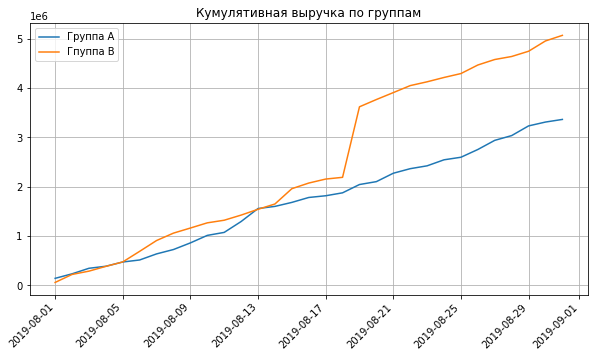

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10, 5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(['Группа А','Гпуппа В'])

plt.show()



Кумулятивная выручка группы В значительно выше чем в группе А, на 13-ый день выручка сравнялась, но далее сильно выросла. На 17-ый день выручка в группе В сильно скачкообразно выросла, возможно дело в дорогих заказах. Для группы А выручка стабильно без всплесков идет вверх, но и для группы В она увеличивается со временем

### Построим график кумулятивного среднего чека по группам

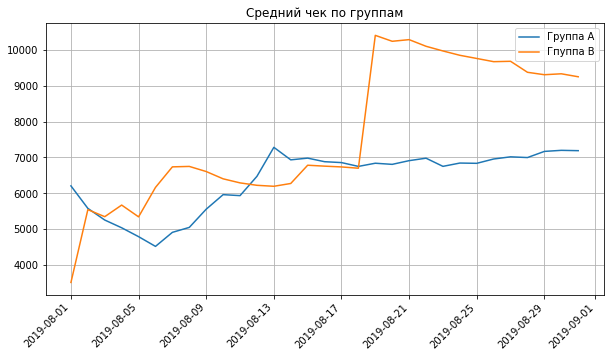

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Средний чек по группам')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(['Группа А','Гпуппа В'])

plt.show()

Средний чек в группе В также значительнее выше чем в группе А. Начиная с 12 по 15-ый день средний чек в обоих группах практически сравнялся, но затем средний чек в группе В значительно вырос относительно группы А. Также на 17-ый средний чек в группе В сильно скачкообразно вырос,а затем начал снижаться. Вероятнее всего попали очень дорогие заказы. И наоборот средний чек в группе А стабилизировался и постепенно растет

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

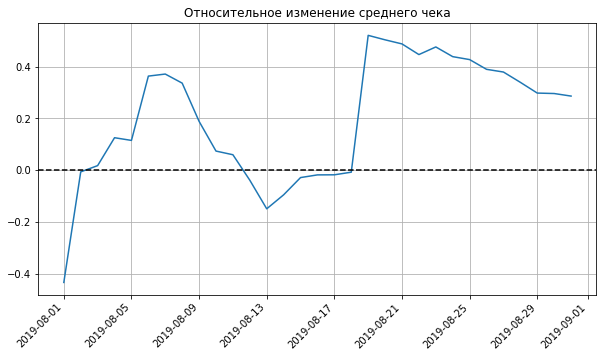

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10, 5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']
                                          )/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменение среднего чека')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

plt.show()

Средний чек группы В сильно доминирует над средним чеком группы А, но не стабильно, с большими всплесками, а в моменте даже снизился относительно группы А. В нескольких точках график относительного изменения кумулятивного среднего чека группы B к группе A сильно скачет. Вероятно что мы имеем дело с крупными заказами или выбросами

### Построим график кумулятивной конверсии по группам

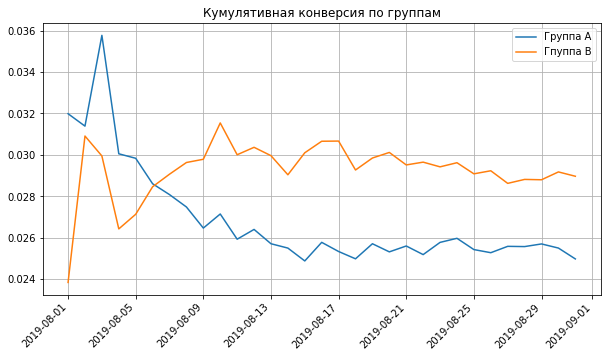

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(['Группа А','Гпуппа В'])
plt.show()


В начале были сильные всплески и группа А была выше тестируемой группы В, затем в моменте конверсия обоих групп пересеклась, далее конверсия группы В на протяжении всего периода теста находилась заметно выше конверсии группы А, но имела постоянную тенденцию к снижению, к концу теста конверсия выровнялась. Конверсия группы А наоборот выровнялась и оставалась стабильной на протяжении теста с незначительным ростом

### Построим график относительного изменения кумулятивной конверсии группы B к группе A

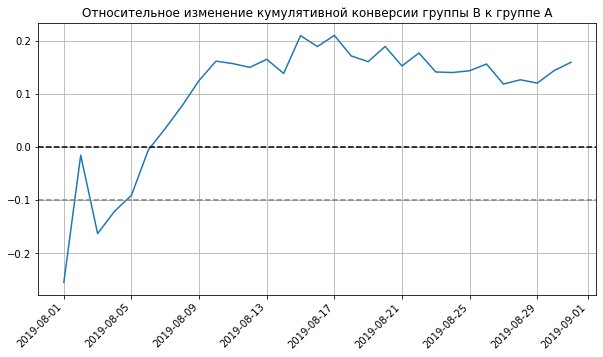

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы В к группе А')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


В начале теста были сильные скачки отношения кумулятивной конверсии группы В к группе А. Если бы мы приняли результат по достижению статистической значимости по первой недели теста то вероятно бы ошиблись. Далее конверсия группы В резко выросла относительно А и держалась выше на протяжении всего теста, хоть и имела тенденцию к снижению. Вероятно выбросы или крупные заказы все таки есть 

### Построим точечный график количества заказов по пользователям

In [26]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsers = ordersByUsers.sort_values(by='transactionId', ascending=False)
ordersByUsers.columns = ['userId', 'orders']

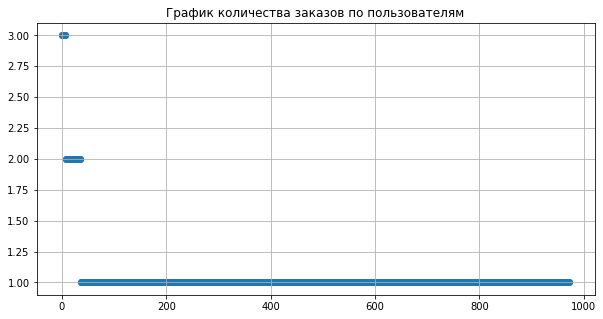

In [27]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям')
plt.grid(True)
plt.show()

Да, действительно есть по 2 и 3 заказа

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [28]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

5% пользователей совершили более одного заказа, и 1 % пользователей совершили более 2-х заказов. За границу аномальных выбросов выберем 99 процентиль, то есть 1% от пользователей, которые совершили более 2-х заказов

### Построим точечный график стоимости заказов

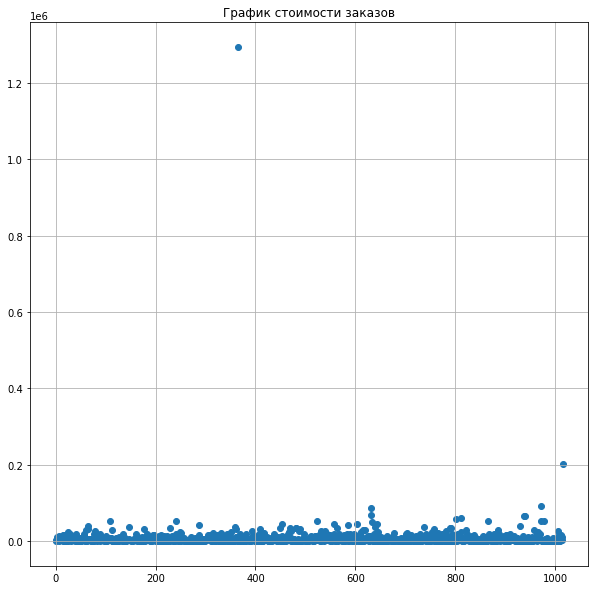

In [29]:
x_values = pd.Series(range(0,len(orders)))
plt.figure(figsize=(10, 10))
plt.scatter(x_values, orders['revenue']) 
plt.title('График стоимости заказов')
plt.grid(True)
plt.show()

У нас есть очень дорогие заказы

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [30]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

5 % заказов дороже 27000, 1% заказов дороже 53904. За границу аномальных выбросов выберем 99 процентиль, то есть 1% дорогих заказов более 53904

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезу:
- H0 - Конверсия группы A равна конверсии группы В
- Н1 - Конверсии группы А и группы В не равны

In [31]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]


ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [32]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [33]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [34]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


По сырым данным есть различие между группами А и В, значение p-value меньше 0.05. То есть мы можем отвергнуть нулевую гипотезу о том что статистически значимая разница между группами отсутствует. Второе значение 0.160 показывает нам значительное превосходство группы В над показателями группы А  на 16%
- Гипотезу "H0 - Конверсия группы A равна конверсии группы В" - не принимаем

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Свормулируем гипотезу:

- H0 - Средний чек группы A равен среднему чеку группы В
- Н1 - Средний чек группы А и группы В не равны

In [35]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


Значение p-value 0.829, это говорит нам о том что разницы между группами А и В по среднему чеку нет, но вот второе значение 0.287 говорит нам что что средний чек группы В больше среднего чека группы А на 29%. Расчет велся по сырым данным. 
- Принимаем "H0 - Средний чек группы A равен среднему чеку группы В"

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [36]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)
abnormalUsers.shape[0]

9

Количество аномальных пользователей = 9. Посмотрим как они повлияли на результаты теста

Сформулируем гипотезу по очищенным данным:
- H0 - Конверсия группы A равна конверсии группы В
- Н1 - Конверсии группы А и группы В не равны

In [37]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [38]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.010
0.164


Результаты теста по очищенным данным практически не изменились относительно теста по сырым данным. Есть статистически значимые различия между группами по конверсии,  то есть мы также можем отвергнуть нулевую гипотезу о равенстве. Отношение конверсии группы В к группе А = 0.164, очень не плохо

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Свормулируем гипотезу по очищенным данным:

- H0 - Средний чек группы A равен среднему чеку группы В
- Н1 - Средний чек группы А и группы В не равны

In [39]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.901
-0.032


Значение p-value 0.901, это говорит нам о том что разницы между группами А и В по среднему чеку в данных после обработки аномалий также нет, второе значение сильно изменилось и средний чек группы В оказался даже ниже группы А на 3%. Выбросы действительно сильно повлияли на данное значение

### Принятие решения по результатам теста. Факты и выводы

Факты:
- Есть статистически значимые различия по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
- График различия конверсии между группами сообщает, что результаты группы B заметно лучше группы A - 16%
- График различия среднего чека говорит о том, что результаты группы B по сырым данным показал нам импульсные колебания за счет значительных выбросов, а после очистки и вовсе стал ниже группы А, разница с 29% до снизилась до -3% после

Вывод:
- Исходя из данных фактов мы можем признать тест успешным в части сравнения конверсии обоих групп. Конверсия группы В действительно выигрыла относительно конверсии контрольной группы А на 16%. Добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, и соответственно сами рассылки дали положительный эффект в виде значительного увеличения конверсии относительно базовой версии страниц сайта. Несмотря на небольшое уменьшение среднего чека в 3%, мы все таки получили существенное увеличение конверсии в 16%